In [2]:
import langgraph
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

In [3]:
import os

llm = ChatOpenAI(model=os.getenv("OPENAI_DEFAULT_MODEL"))

/tmp/ipykernel_25554/3971565783.py:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model=os.getenv("OPENAI_DEFAULT_MODEL"))


In [4]:
def code_style_check(inputs):
    code = inputs["code"]
    prompt = (
        "다음 코드의 스타일을 점검하고 PEP8 준수 여부를 확인하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    inputs["style_feedback"] = response.content
    return inputs

def bug_detection(inputs):
    code = inputs["code"]
    prompt = (
        "다음 코드에서 잠재적인 버그나 논리적 오류를 찾아 설명하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    inputs["bug_feedback"] = response.content
    return inputs

def optimization_suggestions(inputs):
    code = inputs["code"]
    prompt = (
        "다음 코드를 더 효율적으로 최적화할 수 있는 방법을 제안하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    inputs["optimization_feedback"] = response.content
    return inputs

def aggregate_feedback(inputs):
    code = inputs["code"]
    feedback = (
        "코드 스타일 피드백:\n" + inputs["style_feedback"] + "\n\n"
        "버그 가능성 분석:\n" + inputs["bug_feedback"] + "\n\n"
        "최적화 제안:\n" + inputs["optimization_feedback"]
    )
    prompt = (
        "다음 코드와 피드백을 바탕으로 개선된 코드를 작성하세요. 반드시 코드만 출력해야 합니다.\n" + \
            "code: " + code + "\n\n" \
            "피드백: " + feedback
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"code": response.content, "final_feedback": feedback}

In [8]:
from langgraph.graph import StateGraph, START, END

# 1) 상태 스키마용 클래스 정의
class MyState:
    code: str                     # 입력 코드
    style_feedback: str           # 스타일 검사 결과
    bug_feedback: str             # 버그 검사 결과
    optimization_feedback: str    # 최적화 제안 결과
    aggregate_feedback: str       # 최종 피드백 집계 결과

# 2) StateGraph 생성 시 위 클래스를 전달
builder = StateGraph(MyState)

# 3) 노드 등록 (기존 코드 스타일 검사, 버그 탐지 함수 등)
builder.add_node("style_check", code_style_check)
builder.add_node("bug_check", bug_detection)
builder.add_node("optimization_check", optimization_suggestions)
builder.add_node("aggregate", aggregate_feedback)

# 4) 워크플로우 순서 연결
builder.add_edge(START, "style_check")
builder.add_edge("style_check", "bug_check")
builder.add_edge("bug_check", "optimization_check")
builder.add_edge("optimization_check", "aggregate")
builder.add_edge("aggregate", END)

# 5) 최종 컴파일
app = builder.compile()


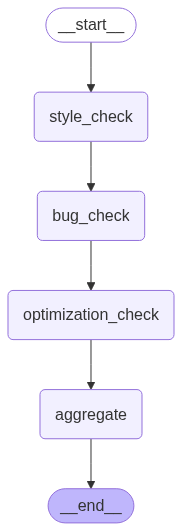

In [9]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
# BEFORE
def code_style_check(state):
    code = state["code"]              # ← 여기가 문제
    feedback = style_llm(state["code"])
    return {"style_feedback": feedback}

# AFTER
def code_style_check(state: MyState):
    # dataclass / BaseModel의 속성 접근
    code = state.code                 
    feedback = style_llm(code)
    # 노드는 변경할 필드만 dict로 반환
    return {"style_feedback": feedback}


In [16]:
# 예시: 스타일 검사 노드
def code_style_check(state: MyState):
    # 📌 state["code"] → state.code
    code = state.code
    feedback = style_llm(HumanMessage(content="다음 코드의 스타일을 점검하고 PEP8 준수 여부를 확인하세요:\n" + code))
    return {"style_feedback": feedback.content}

# 예시: 버그 탐지 노드
def bug_detection(state: MyState):
    # 📌 state["code"] → state.code
    code = state.code
    feedback = bug_llm(HumanMessage(content="다음 코드에서 잠재적 버그를 찾아 설명하세요:\n" + code))
    return {"bug_feedback": feedback.content}

# 예시: 최적화 제안 노드
def optimization_suggestions(state: MyState):
    # 📌 state["code"] → state.code
    code = state.code
    feedback = opt_llm(HumanMessage(content="다음 코드의 최적화 방안을 제안하세요:\n" + code))
    return {"optimization_feedback": feedback.content}

# 예시: 피드백 집계 노드
def aggregate_feedback(state: MyState):
    # 📌 state["style_feedback"] → state.style_feedback 등
    agg = (
        "★ 스타일 검사 결과\n"   + state.style_feedback   + "\n\n"
      + "★ 버그 탐지 결과\n"   + state.bug_feedback     + "\n\n"
      + "★ 최적화 제안 결과\n" + state.optimization_feedback
    )
    return {"aggregate_feedback": agg}
